In [33]:
%matplotlib inline
import bluepyopt as bpop
import epileptor_evaluator
import epileptor_util
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt
import pickle
import ukf


def save_obj(obj, name):
    with open('obj/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    with open('obj7470671_success/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    

def plot_sim_trace(sim, *argv):
    plt.figure(figsize=(10,2))
    plt.plot(sim.noisy_data[0], *argv)
    plt.show()

In [70]:
def reload_packages():
    global epileptor_util, epileptor_evaluator, ukf
    epileptor_util = reload(epileptor_util)
    epileptor_evaluator = reload(epileptor_evaluator)
    ukf = reload(ukf)

## Load the parameters from the BluePy optimization

In [21]:
params0 = load_obj('params0')
params0

{'Irest1': 3.3470680439849545,
 'Irest2': 0.38821130450868535,
 'a': 4.801423747418066,
 'b': 6.283489028335293,
 'c': 0.5888883180794066,
 'd': 3.5120277311467927,
 'g_init': 0.0,
 'gamma': 0.01,
 'noise_ensemble1': 0.0,
 'noise_ensemble2': 0.0,
 'observation_sigmas': 0.0,
 'tau0': 3896.6380854798267,
 'tau1': 1.0,
 'tau2': 10.0,
 'x0': -1.6,
 'x1_init': 0.0,
 'x2_init': 0.0,
 'y0': 1.0,
 'y1_init': -5.7342472275046585,
 'y2_init': 0.0,
 'z_init': 2.864188322543963}

## Get target
If the target is not saved (i.e. not from data or simulation was not explicitly saved), generate a new one using default parameters.

In [92]:
reload_packages()

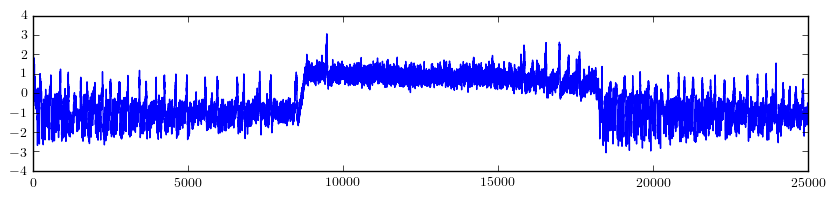

In [93]:
target = epileptor_util.epileptor_model()
target.generate_simulation(plot=False)
plot_sim_trace(target)

Create the epileptor model object using the optimized parameters and set the noisy_data attribute of the object to the target data.

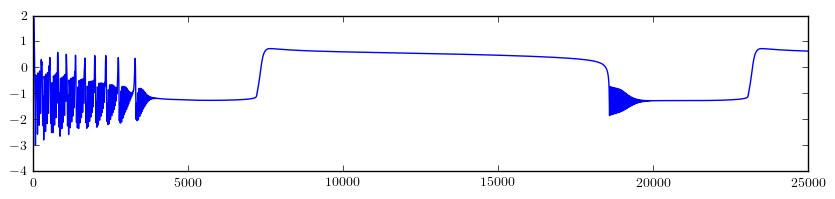

In [102]:
sim = epileptor_util.epileptor_model(params=params0)
sim.generate_simulation(plot=False)
plot_sim_trace(sim)
sim.noisy_data = target.noisy_data

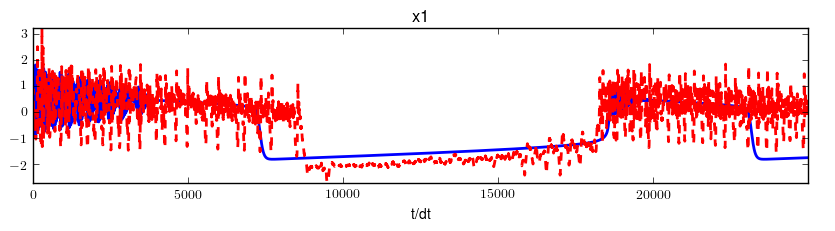

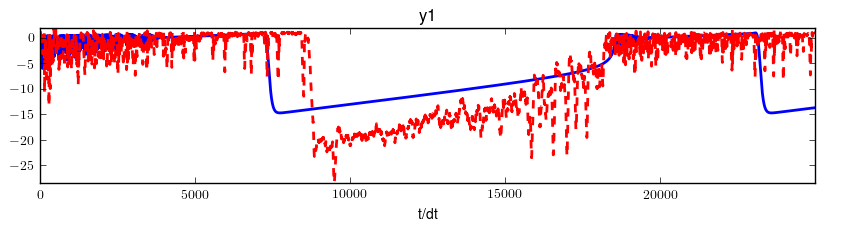

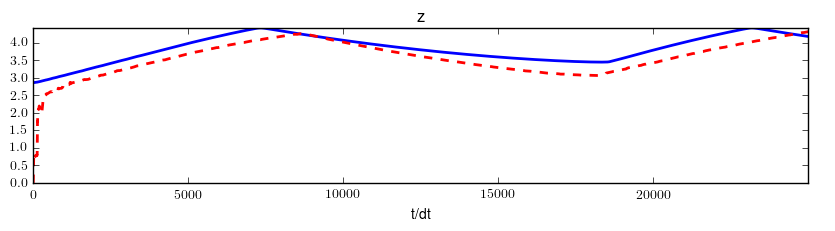

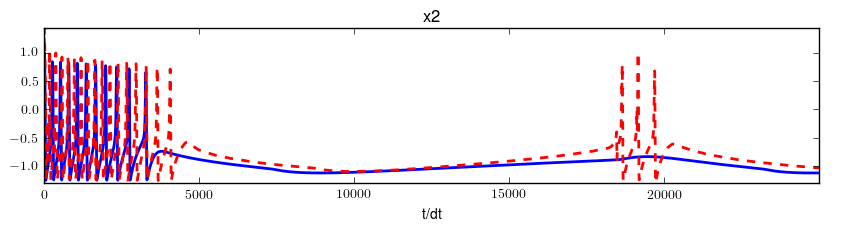

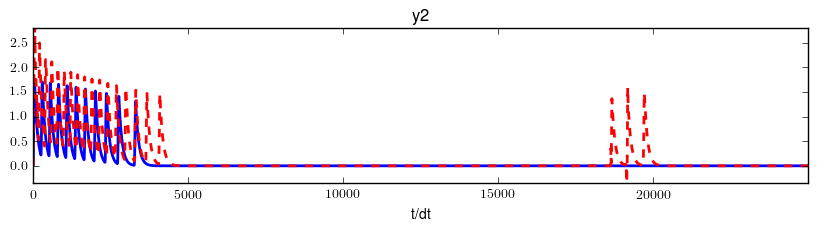

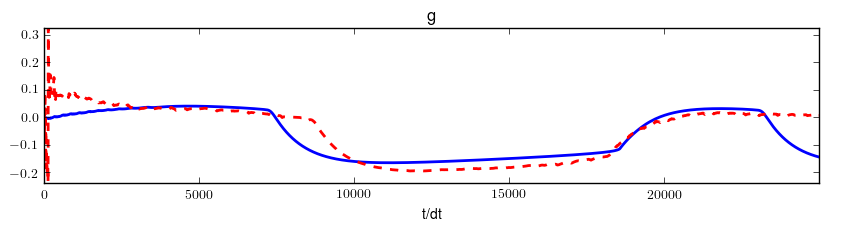

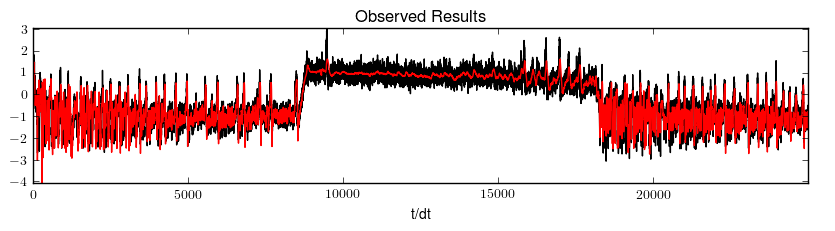

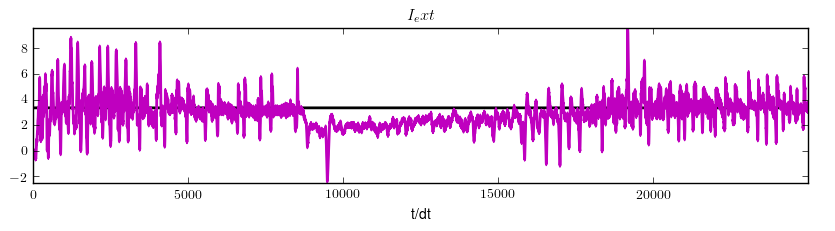

In [101]:
# reload_packages()
kf = ukf.unscented_kalman_filter(sim)
kf.unscented_kalman(initial_estimate='model')
kf.plot_filter_results(separated=True)

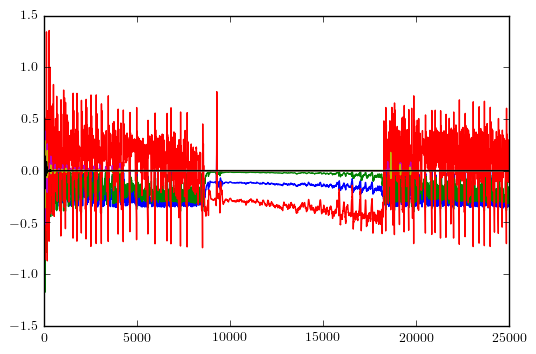

In [107]:
plt.plot(kf.Ks.reshape(7, 25000).T)
plt.show()

## After changing I_ext to reflect current injected into the second ensemble

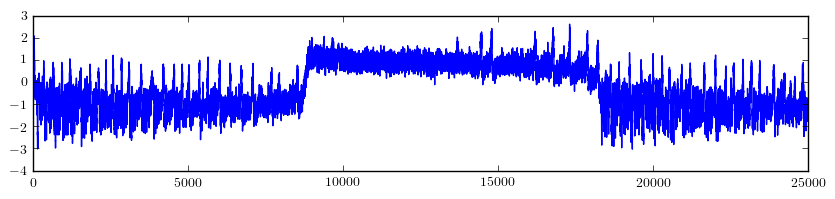

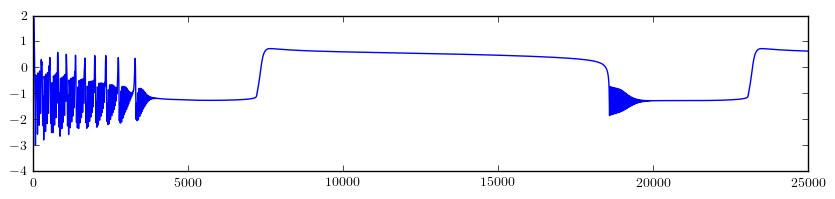

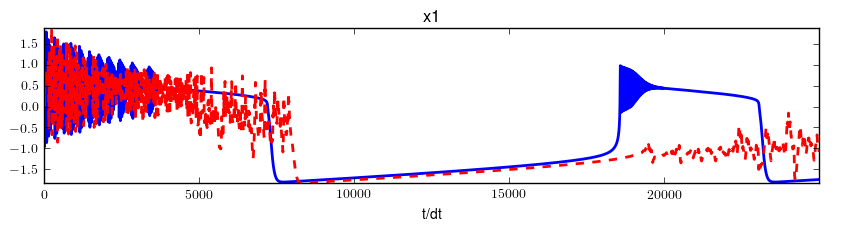

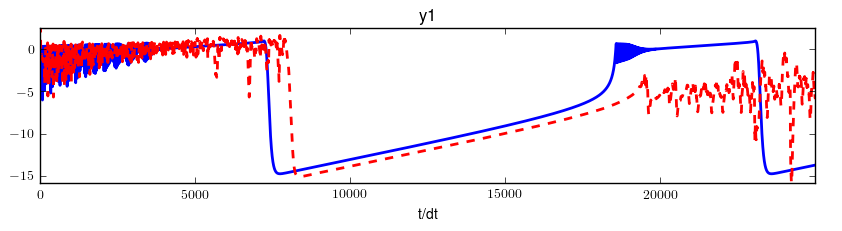

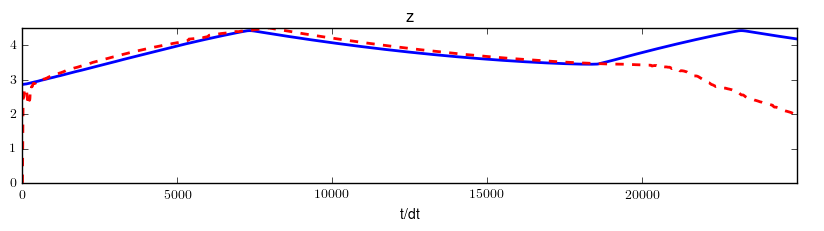

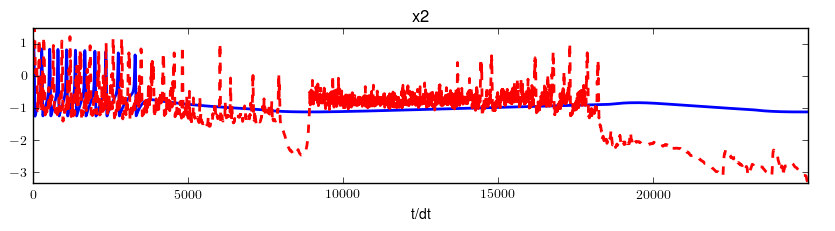

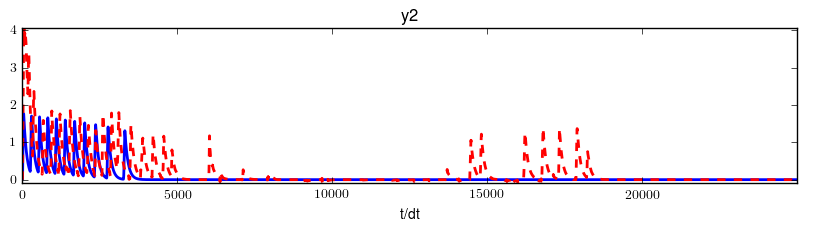

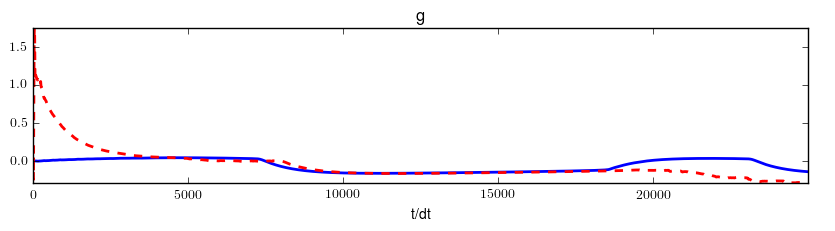

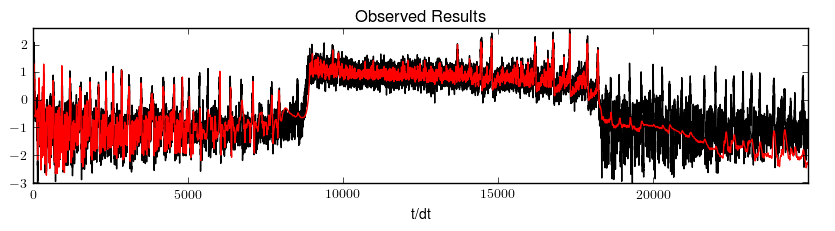

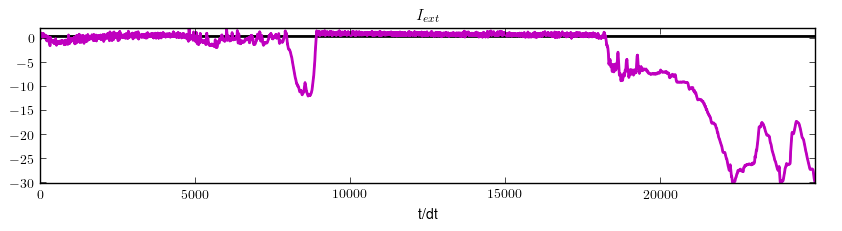

In [108]:
reload_packages()
target = epileptor_util.epileptor_model()
target.generate_simulation(plot=False)
plot_sim_trace(target)
sim = epileptor_util.epileptor_model(params=params0)
sim.generate_simulation(plot=False)
plot_sim_trace(sim)
sim.noisy_data = target.noisy_data
kf = ukf.unscented_kalman_filter(sim)
kf.unscented_kalman(initial_estimate='model')
kf.plot_filter_results(separated=True)

## After adding I_ext parameters for both ensembles and the z variable
By changing the _parameter_sigma_ attribute we can focus on any subset of the parameters. For example

    parameter_sigma=[0, 15e-3, 0]

will run such that only the current injected into the second ensemble is allowed to vary. Note that in the program a sigma of zero is reset to 1e-16 so that the Cholesky decomposition can still be used to generate the sigma points.

Running with all three parameters makes a mess. The following, however, works reasonably well:
    
    parameter_sigma=[15e-3, 15e-4, 0]

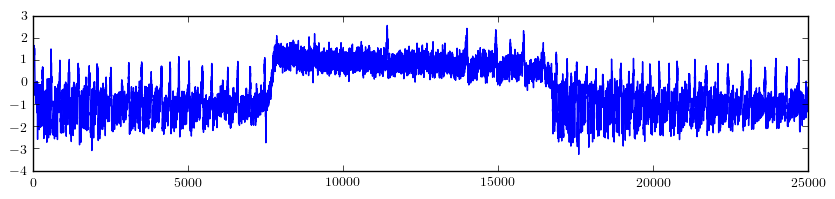

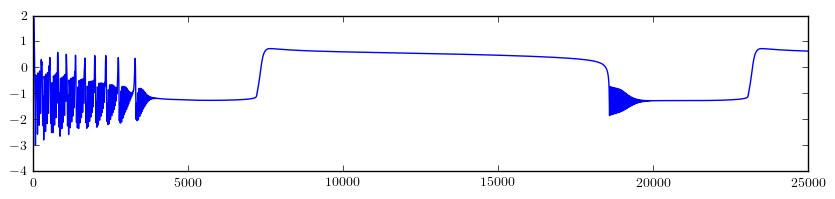

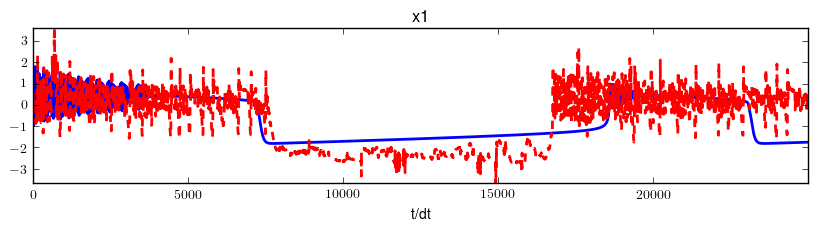

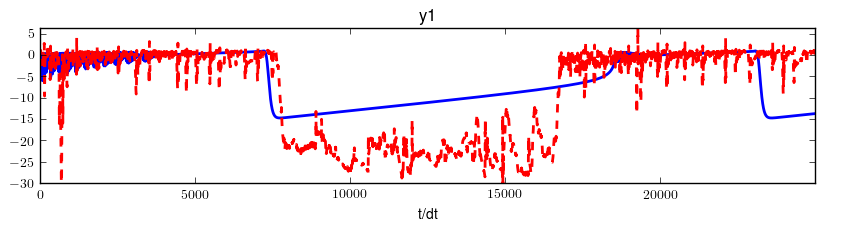

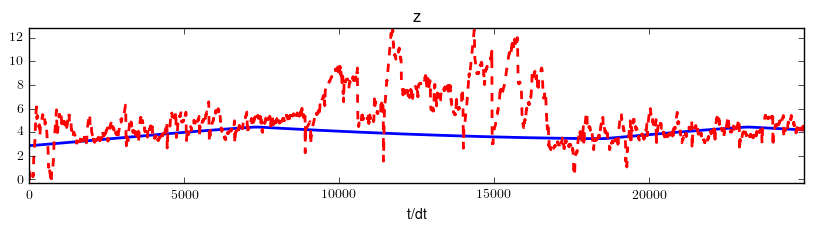

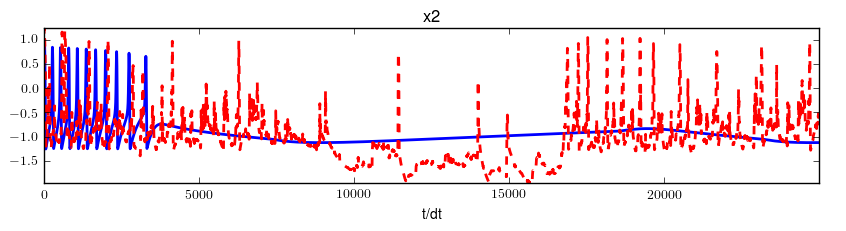

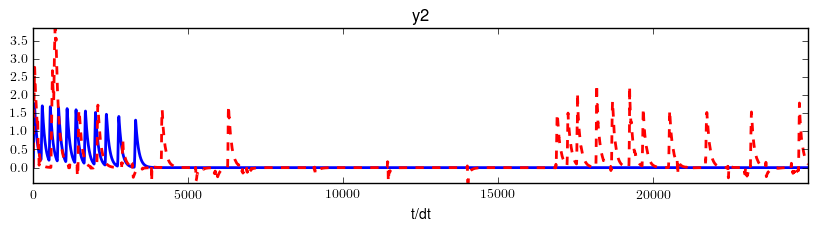

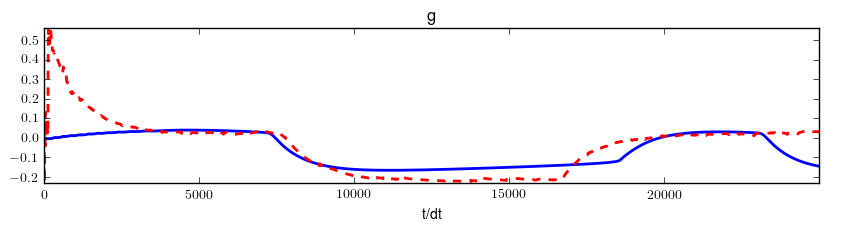

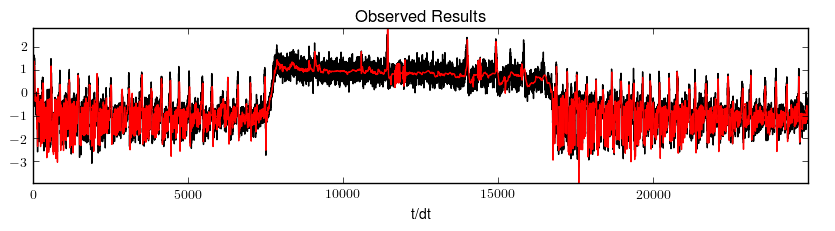

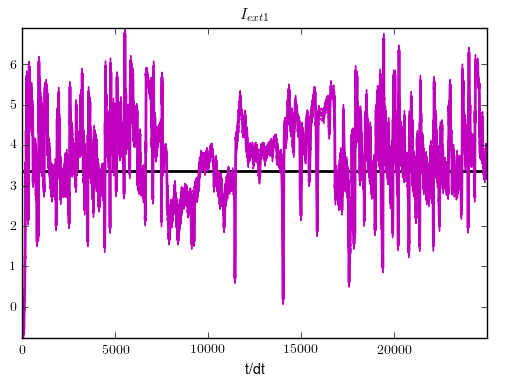

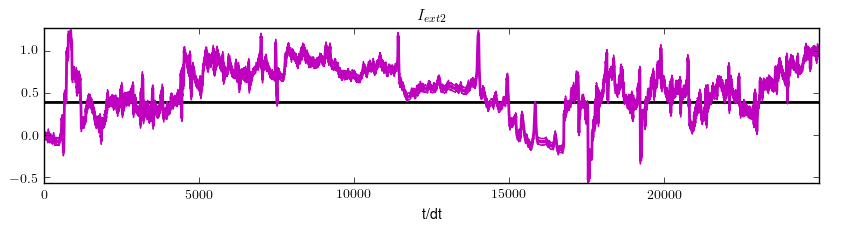

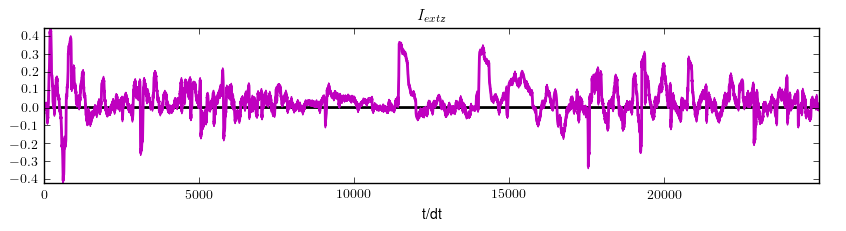

In [158]:
reload_packages()
target = epileptor_util.epileptor_model()
target.generate_simulation(plot=False)
plot_sim_trace(target)
sim = epileptor_util.epileptor_model(params=params0)
sim.generate_simulation(plot=False)
plot_sim_trace(sim)
sim.noisy_data = target.noisy_data
kf = ukf.unscented_kalman_filter(sim, parameter_sigma=[15e-3, 15e-4, 15e-5])
kf.unscented_kalman(initial_estimate='model')
kf.plot_filter_results(separated=True)

## Second pass
In this case, setting the initial estimate of the parameters to the final state of the parameters from a previous run does not make a huge improvement. The parameters were initialized to zero in the first place, though, which is at most 3.1 away from the actual value (in the case of _Irest1_).

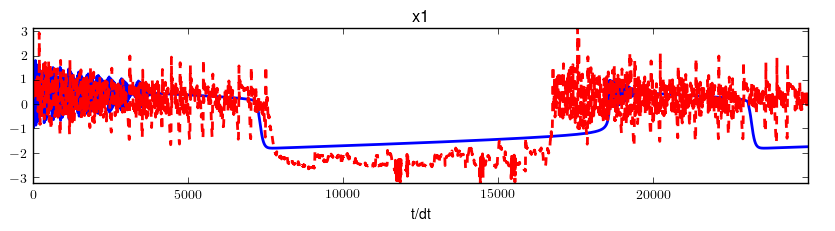

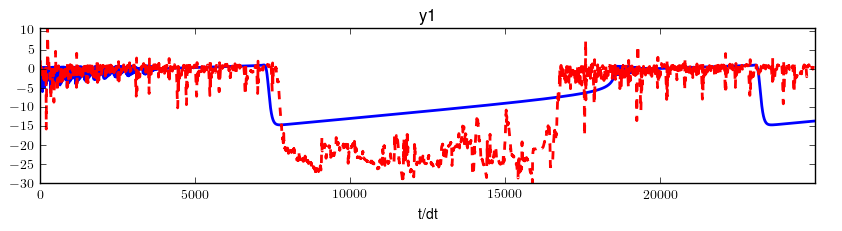

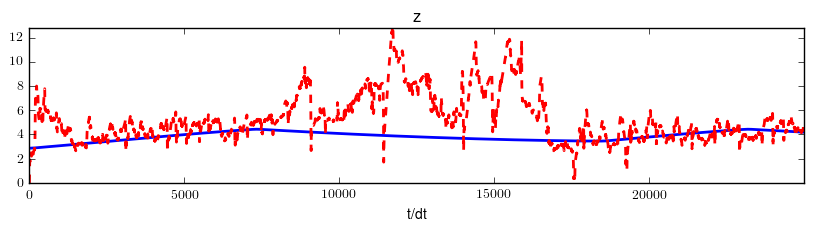

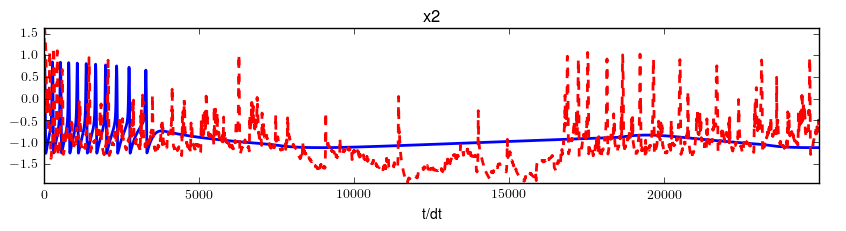

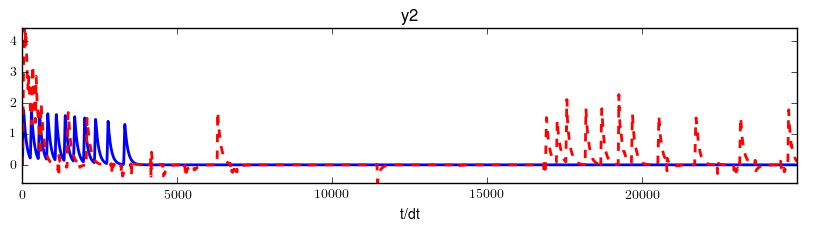

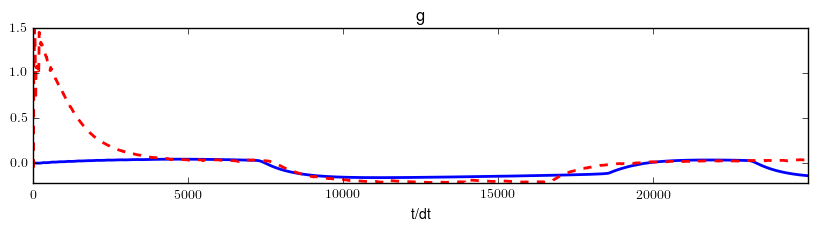

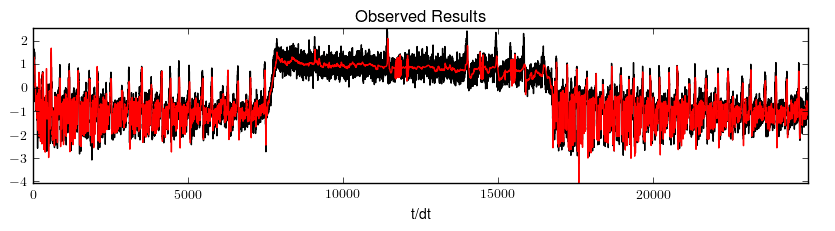

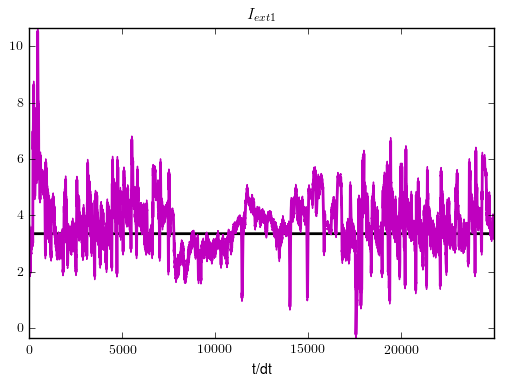

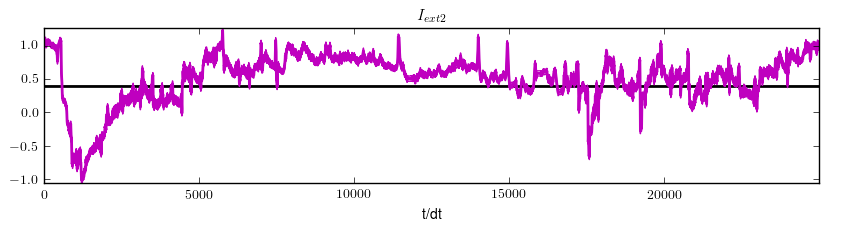

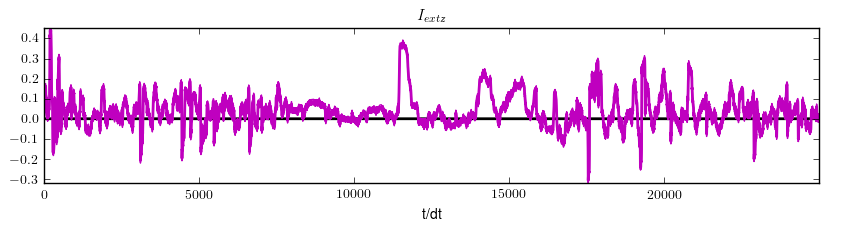

In [159]:
initial_estimate = kf.estimated_state[:, 0]
initial_estimate[:kf.model.dims_params] = kf.estimated_state[:kf.model.dims_params, -1]
kf.unscented_kalman(initial_estimate=initial_estimate)
kf.plot_filter_results(separated=True)